### Assignment 1 (Group 142)
<ul><li>SURESH BABASAHEB NIMBALKAR (2019HC04104)</li>
    <li>WAVHAL HEMANT SUDHIR (2019HC04093)</li>
    <li>SURAJ KUMAR (2019HC04912)</li>
</ul>
<font color=blue><b>NLP Assignment - Create MultinomialNB Model for Movie Review data, POS Tagging and Dependency Parser Tree</b></font>
<br><br>
Description of Data: This dataset contains 1000 positive and 1000 negative processed reviews.
<br>
Link to the Dataset: https://www.kaggle.com/nltkdata/movie-review?select=movie_review.csv
<br>

### Import Libraries

In [1]:
# import general purpose libraries
import pandas as pd
import numpy as np
import pickle as pk
import re
import time
import unicodedata
import string

# import plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

#nltk related libraries
import spacy as sp
from spacy import displacy
from scipy import sparse
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem import PorterStemmer
from nltk import (corpus, word_tokenize, WordNetLemmatizer, pos_tag)
from sklearn import (feature_extraction, datasets, linear_model, naive_bayes, ensemble, model_selection)
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

# importing metrics libraries accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.model_selection import GridSearchCV

# For nice progress bar
from tqdm import tqdm

tqdm.pandas()

In [2]:
#Overall Program Execution Time
program_start_time = time.time()

## Approach 1
- **Loading data from CSV File**, which contains individual lines (and not grouped by file)
- Cleansing data
- Use countvectorize 
- Run Model and find accuracy

### Download the file and set it as a Dataframe

In [3]:
reviews_df = pd.read_csv('movie_review.csv')
reviews_df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


pos    32937
neg    31783
Name: tag, dtype: int64


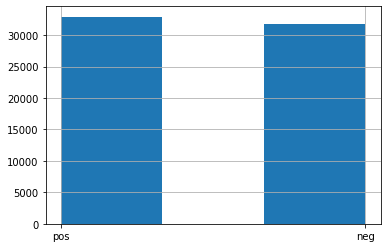

In [4]:
reviews_df.tag.hist(bins=3)
print(reviews_df.tag.value_counts())

100%|██████████| 64720/64720 [00:22<00:00, 2819.08it/s]


count    64720.000000
mean        20.423888
std         12.066022
min          0.000000
25%         12.000000
50%         19.000000
75%         27.000000
max        156.000000
Name: text_len, dtype: float64

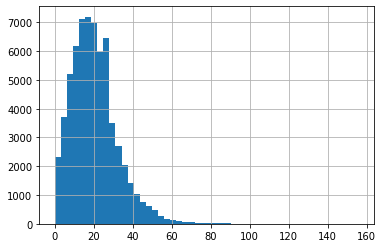

In [5]:
reviews_df['text_len'] = reviews_df.text.progress_apply(lambda txt: len(TextBlob(txt).words))
reviews_df.text_len.hist(bins=50)
reviews_df.text_len.describe()

In [6]:
## TODO
## probably we need to remove too short reviews
reviews_df[reviews_df.text_len <= 3].head()

,fold_id,cv_tag,html_id,sent_id,text,tag,text_len
48,0,cv001,18431,23,and so on .,pos,3
49,0,cv001,18431,24,what happened ?,pos,2
86,0,cv003,11664,3,dah-dum .,pos,1
316,0,cv010,29198,37,but enough carping .,pos,3
438,0,cv015,29439,17,you see . . . dreams,pos,3


In [7]:
# Checking the existing list of stopwords

stopWords = corpus.stopwords.words("english")
print("NLTK's STOP WORDS LIST:\n\t", stopWords)

NLTK's STOP WORDS LIST:
	 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

### Remove punctuations, special characters and stopwords from the text column. Convert the text to lower case

In [8]:
tokenizer = ToktokTokenizer()
# custom: removing words from list
stopWords.remove('not')

# function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# function to remove special characters
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

# function to remove_extra_whitespace_tabs
def remove_extra_whitespace_tabs(text):
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

# function to remove punctuation
def remove_punctuation(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

# function to remove stopwords
def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopWords]
    text = ' '.join(t)    
    return text

# function to remove special characters
def to_lowercase(text):
    return text.lower()

In [9]:
reviews_df['processed_text'] = reviews_df.text.progress_apply(lambda txt: remove_accented_chars(txt))
reviews_df['processed_text'] = reviews_df.processed_text.progress_apply(lambda txt: remove_special_characters(txt))
reviews_df['processed_text'] = reviews_df.processed_text.progress_apply(lambda txt: remove_extra_whitespace_tabs(txt))
reviews_df['processed_text'] = reviews_df.processed_text.progress_apply(lambda txt: remove_punctuation(txt))
reviews_df['processed_text'] = reviews_df.processed_text.progress_apply(lambda txt: remove_stopwords(txt))
reviews_df['processed_text'] = reviews_df.processed_text.progress_apply(lambda txt: to_lowercase(txt))

100%|██████████| 64720/64720 [00:00<00:00, 763454.35it/s]


100%|██████████| 64720/64720 [00:17<00:00, 3605.95it/s]


count    64720.000000
mean        11.062763
std          6.824728
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         79.000000
Name: processed_text_len, dtype: float64

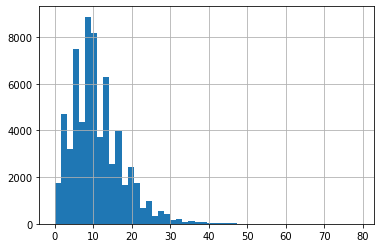

In [10]:
reviews_df['processed_text_len'] = reviews_df.processed_text.progress_apply(lambda txt: len(TextBlob(txt).words))
reviews_df.processed_text_len.hist(bins=50)
reviews_df.processed_text_len.describe()

In [11]:
## TODO
## probably we need to remove too short reviews
reviews_df[reviews_df.processed_text_len <= 3]

,fold_id,cv_tag,html_id,sent_id,text,tag,text_len,processed_text,processed_text_len
23,0,cv000,29590,23,"the film , however , is all good .",pos,6,film however good,3
28,0,cv001,18431,3,the plot is deceptively simple .,pos,5,plot deceptively simple,3
37,0,cv001,18431,12,the similarities are staggering :,pos,4,similarities staggering,2
48,0,cv001,18431,23,and so on .,pos,3,,0
49,0,cv001,18431,24,what happened ?,pos,2,happened,1
...,...,...,...,...,...,...,...,...,...
64587,9,cv995,23113,52,which one is it ?,neg,4,one,1
64629,9,cv996,12447,24,"the penis is evil . """,neg,4,penis evil,2
64677,9,cv998,15691,7,the story is simple .,neg,4,story simple,2
64698,9,cv999,14636,3,"emphasis on the word "" presumably . """,neg,5,emphasis word presumably,3


### Create two objects X and y. X will be the 'text' column dataframe and y will be the “tag” column. create a CountVectorizer object and split the data into training and testing sets. Train a MultinomialNB model and Display the confusion Matrix

#### Create two objects X and y. X will be the 'text' column dataframe and y will be the “tag” column, create CountVectorizer

In [12]:
# Create a Vectorizer Object
vectorizer = CountVectorizer()

# creating features 
X = vectorizer.fit_transform(list(reviews_df.processed_text))

# creating labels 
y = [1 if (i == "pos") else 0 for i in reviews_df.tag]

# Listing vectorizer features
print(f"There are total {len(vectorizer.get_feature_names())} features in the matrix")
print("some of the features are: ", vectorizer.get_feature_names()[0:-1:10000])

# Listing y labels
unique, counts = np.unique(y, return_counts=True)
print("\nY Labels -> ",unique, counts)

# cross check with dataframe
print("\nData tag summary\n",reviews_df.groupby(['tag']).size())

There are total 47355 features in the matrix
some of the features are:  ['00', 'custody', 'hottempered', 'overpraised', 'steamier']

Y Labels ->  [0 1] [31783 32937]

Data tag summary
 tag
neg    31783
pos    32937
dtype: int64


#### Create Train, Test Split (80:20)

In [13]:
# splitting features and labels into training and testing data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train:Test split", X_train.get_shape(), ":", X_test.get_shape())

Train:Test split (51776, 47355) : (12944, 47355)


#### Train a MultinomialNB model and Display the confusion Matrix

Accuracy with normal features using Multinomial Naive Bayes: 0.7048053152039555
Confusion Matrix

[[4466 1905]
 [1916 4657]]


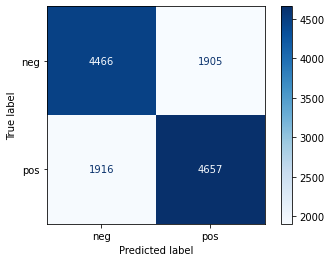

In [14]:
# MultinomialNB Model Training and Score
nb = naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)
print("Accuracy with normal features using Multinomial Naive Bayes:", nb.score(X_test, y_test))

y_pred = nb.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)


plot_confusion_matrix(nb, X_test, y_test,
                                 display_labels=['neg', 'pos'],
                                 cmap=plt.cm.Blues)

#### Printing other metrics, and classification matrix

In [15]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['neg', 'pos']))


Accuracy: 0.70

Weighted Precision: 0.70
Weighted Recall: 0.70
Weighted F1-score: 0.70

Classification Report

              precision    recall  f1-score   support

         neg       0.70      0.70      0.70      6371
         pos       0.71      0.71      0.71      6573

    accuracy                           0.70     12944
   macro avg       0.70      0.70      0.70     12944
weighted avg       0.70      0.70      0.70     12944



### Display the POS tagging on the first 4 rows of ‘text’

In [16]:
for i in range(4):
    print("="*60, "Row #",i)
    print()
    print("*** Original ***\n",reviews_df.text[i])
    print()
    #print("*** POS Tag of Original ***\n",nltk.pos_tag(nltk.word_tokenize(reviews_df.text[i])))
    #print()
    print("*** Processed ***\n", reviews_df.processed_text[i])
    print()
    print("*** POS Tag of Processed ***\n",nltk.pos_tag(nltk.word_tokenize(reviews_df.processed_text[i])))
    print()

============================================================ Row # 0

*** Original ***
 films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before .

*** Processed ***
 films adapted comic books plenty success whether theyre superheroes batman superman spawn geared toward kids casper arthouse crowd ghost world theres never really comic book like hell

*** POS Tag of Processed ***
 [('films', 'NNS'), ('adapted', 'VBD'), ('comic', 'JJ'), ('books', 'NNS'), ('plenty', 'JJ'), ('success', 'NN'), ('whether', 'IN'), ('theyre', 'NN'), ('superheroes', 'NNS'), ('batman', 'JJ'), ('superman', 'JJ'), ('spawn', 'NN'), ('geared', 'VBN'), ('toward', 'IN'), ('kids', 'NNS'), ('casper', 'NN'), ('arthouse', 'IN'), ('crowd', 'NN'), ('ghost', 'NN'), ('world', 'NN'), ('theres', 'VBZ'), ('never', 'RB'), ('rea

## Approach 2
- **Loading Raw Files** instead of using CSV File
- Cleansing data
- Use countvectorize 
- Run Model and find accuracy

#### Loading Raw Files from the Folder - movie_reviews into dataframe

In [17]:
dataset = load_files('movie_reviews')

features, labels = dataset.data, dataset.target

print("Feature Loaded ->", len(features), len(labels))
unique, counts = np.unique(labels, return_counts=True)
print("Unique Label ->", unique, counts)

Feature Loaded -> 2000 2000
Unique Label -> [0 1] [1000 1000]


#### Cleansing the data - Remove punctuations, special characters and stopwords from the text column. Convert the text to lower case.

In [18]:
# Preprocessing data
new_corpus = []
stopwords = corpus.stopwords.words("english")

for i in range(len(features)):
    
    # Removing all punctuation marks and non characters
    review = re.sub(r'\W', ' ', str(features[i]))
    
    # Converting into lowercase
    review = review.lower()
    
    # Removing b from starting of string
    review = re.sub(r'^b\s+', '', review)
    
    # Removing all single characters
    review = re.sub(r'\s+[a-z]\s+', ' ', review)
    
    # Removing all words which is of length one
    review = re.sub(r'[^a-z]\s+', ' ', review)
    
    # Removing all extra spaces
    review = re.sub(r'\s+', ' ', review)
    
    # Remove stop words
    review = remove_stopwords(review)
    
    # Adding cleaned reviews in corpus
    new_corpus.append(review)

#### Create a Count Vectorizer object

In [19]:
# Creating Count Vectorizer model
vectorizer = CountVectorizer(max_features=2000,
                             min_df=3,
                             max_df=.6,
                             stop_words=stopwords)

vectorizer_model = vectorizer.fit_transform(new_corpus).toarray()

# Listing vectorizer features
print(f"There are total {len(vectorizer.get_feature_names())} features in the matrix")
print("some of the features are: ", vectorizer.get_feature_names()[10:20])

There are total 2000 features in the matrix
some of the features are:  ['academy', 'accent', 'accept', 'accident', 'across', 'act', 'acted', 'acting', 'action', 'actions']


#### Create Train, Test Split (80:20)

In [20]:
# Train Test Split for 80:20
# Splitting dataset into train and test sets
feature_train, feature_test, labels_train, labels_test = train_test_split(vectorizer_model,
                                                                          labels,
                                                                          test_size=.2,
                                                                          random_state=42)

print("Train:Test split", len(feature_train), ":", len(feature_test))

Train:Test split 1600 : 400


#### Train a MultinomialNB model and Display the confusion Matrix

Accuracy with normal features using Multinomial Naive Bayes: 0.82
Confusion matrix: 
 [[158  32]
 [ 40 170]]


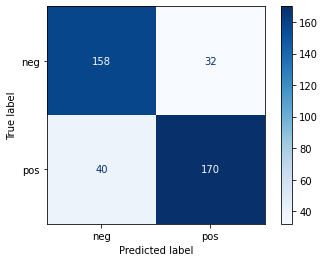

In [21]:
# Default Training Logistic Regression model
classifier = naive_bayes.MultinomialNB()
classifier.fit(feature_train, labels_train)
print("Accuracy with normal features using Multinomial Naive Bayes:", classifier.score(feature_test, labels_test))

# Predicting values
labels_pred = classifier.predict(feature_test)

# Testing model performance
print('Confusion matrix: \n', confusion_matrix(labels_test, labels_pred))

plot_confusion_matrix(classifier, feature_test, labels_test,
                                 display_labels=['neg', 'pos'],
                                 cmap=plt.cm.Blues)

#### Printing other metrics, and classification matrix

In [22]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels_test, labels_pred)))
print('Weighted Precision: {:.2f}'.format(precision_score(labels_test, labels_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels_test, labels_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels_test, labels_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(labels_test, labels_pred, target_names=['neg', 'pos']))


Accuracy: 0.82

Weighted Precision: 0.82
Weighted Recall: 0.82
Weighted F1-score: 0.82

Classification Report

              precision    recall  f1-score   support

         neg       0.80      0.83      0.81       190
         pos       0.84      0.81      0.83       210

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



### Perform Hyperparameter tuning using GridsearchCV to find optimal 'alpha' to improve accuracy, we use Approach 2 as the accuracy is higher compared to Approach 1 i.e. CSV file load method 

In [23]:
# Hyper Parameter Tuning
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
grid_search= GridSearchCV(classifier, parameters, n_jobs=-1, cv=10, scoring='accuracy')
grid_search.fit(feature_train,labels_train)

# Displaying best hyperparameters
print('Accuracy :', grid_search.best_score_)
print('Best Parameters :', grid_search.best_params_)
print('Best Estimator :\n', grid_search.best_estimator_)

Accuracy : 0.8162499999999999
Best Parameters : {'alpha': 0.1}
Best Estimator :
 MultinomialNB(alpha=0.1)


#### Running model with optimal 'alpha' value

In [24]:
# Setting MultinomialNB with identified best parameters
classifier = naive_bayes.MultinomialNB(alpha=0.1)
classifier.fit(feature_train, labels_train)

# Predicting values
labels_pred = classifier.predict(feature_test)

# Testing model performance
print('Confusion matrix: \n', confusion_matrix(labels_test, labels_pred))
print('Accuracy: ', accuracy_score(labels_test, labels_pred))

Confusion matrix: 
 [[158  32]
 [ 39 171]]
Accuracy:  0.8225


### Summary / Findings
- When using raw files as against using CVS file, we got >80% accuracy (as against 70%)
- With Hyperparameter tuning, the accuracy score improved to >82%

### Display the POS tagging on the first 4 rows of ‘text’

In [25]:
class_name = ['neg', 'pos']
for i in range(4):
    print()
    print("-"*40, "Row#", i, "Review Type=",class_name[labels[i]])
    print("*** Original Review ->\n",features[i])
    print()
    print("*** Cleaned Review ->\n",new_corpus[i])
    print()
    print("*** POS Tag of Processed ***\n",nltk.pos_tag(nltk.word_tokenize(new_corpus[i])))


---------------------------------------- Row# 0 Review Type= neg
*** Original Review ->
 b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of th

### Saving Cleaned Features, Labels and Model for Future Use (to avoid processing time)

In [26]:
# Persisting the datasets to save time on furthur load
with open('features.pickle', 'wb') as f:
    pk.dump(features, f)
    
with open('labels.pickle', 'wb') as f:
    pk.dump(labels, f)
    
# Saving Tfidf model and vectorizer
with open('vectorizer.pickle', 'wb') as f:
    pk.dump(vectorizer, f)
    
with open('model.pickle', 'wb') as f:
    pk.dump(classifier, f)

## Build and display a dependency parser tree for the given sentence

### Method 1 : Building Dependency Parser on Original Text

In [27]:
nlp=sp.load('en_core_web_sm')

text="Following Jon's death in a mutiny, he is one of Jon's loyalists who find his body and barricade themselves inside his quarters, refusing to acknowledge Thorne's leadership."
print("Original Text\n", text)
print()

for token in nlp(text):
    print(token.text,'=>',token.dep_,'=>',token.head.text)
    
displacy.render(nlp(text),jupyter=True)

Original Text
 Following Jon's death in a mutiny, he is one of Jon's loyalists who find his body and barricade themselves inside his quarters, refusing to acknowledge Thorne's leadership.

Following => prep => is
Jon => poss => death
's => case => Jon
death => pobj => Following
in => prep => death
a => det => mutiny
mutiny => pobj => in
, => punct => is
he => nsubj => is
is => ROOT => is
one => attr => is
of => prep => one
Jon => poss => loyalists
's => case => Jon
loyalists => pobj => of
who => nsubj => find
find => relcl => loyalists
his => poss => body
body => dobj => find
and => cc => find
barricade => conj => find
themselves => dobj => barricade
inside => prep => barricade
his => poss => quarters
quarters => pobj => inside
, => punct => is
refusing => advcl => is
to => aux => acknowledge
acknowledge => xcomp => refusing
Thorne => poss => leadership
's => case => Thorne
leadership => dobj => acknowledge
. => punct => is


### Method 2 : Building Dependency Parser on Cleansed Text
#### Due to apostrophe comma the dependency treats them as seperate words, and accordingly creates the tree. 

In [28]:
nlp=sp.load('en_core_web_sm')

text="Following Jon's death in a mutiny, he is one of Jon's loyalists who find his body and barricade themselves inside his quarters, refusing to acknowledge Thorne's leadership."
print("Original Text\n", text)
print()
text = remove_special_characters(text)
text = remove_punctuation(text)
print("Cleansed Text\n", text)
print()
for token in nlp(text):
    print(token.text,'=>',token.dep_,'=>',token.head.text)
    
displacy.render(nlp(text),jupyter=True)

Original Text
 Following Jon's death in a mutiny, he is one of Jon's loyalists who find his body and barricade themselves inside his quarters, refusing to acknowledge Thorne's leadership.

Cleansed Text
 Following Jons death in a mutiny he is one of Jons loyalists who find his body and barricade themselves inside his quarters refusing to acknowledge Thornes leadership

Following => ROOT => Following
Jons => compound => death
death => pobj => Following
in => prep => death
a => det => mutiny
mutiny => pobj => in
he => nsubj => is
is => relcl => mutiny
one => attr => is
of => prep => one
Jons => compound => loyalists
loyalists => pobj => of
who => nsubj => find
find => relcl => loyalists
his => poss => body
body => dobj => find
and => cc => find
barricade => conj => find
themselves => dobj => barricade
inside => prep => barricade
his => poss => quarters
quarters => pobj => inside
refusing => advcl => barricade
to => aux => acknowledge
acknowledge => xcomp => refusing
Thornes => compound =

In [29]:
secs = time.time() - program_start_time
mins = secs / 60
print("Overall time took %s seconds ---" % "{:.2f}".format(secs))
print("Overall time took %s mins ---" % "{:.2f}".format(mins))

Overall time took 70.10 seconds ---
Overall time took 1.17 mins ---
